In [15]:
from pymystem3 import Mystem
from nltk.corpus import stopwords
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import numpy as np

In [2]:
russian_stopwords = stopwords.words("russian")
m = Mystem()

In [7]:
special = ['beg', 'haps', 'sads', 'excl', 'point', 'myst', 'en', 'не']

def word_map_punct(word):
    happy_smiles = [':)', ';)', ':-)', ':D', ':P', ';-)', '(:', '(-:', '((']
    sad_smiles = [':(', ';(', ':-(', 'D:', ';-(', '):', ')-:', '))']
    for smile in happy_smiles:
        if smile in word:
            return 'haps'
    for smile in sad_smiles:
        if smile in word:
            return 'sads'
    if '!' in word:
        return 'excl'
    if '...' in word:
        return 'myst'
    if '.' in word:
        return 'point'
    return word

def map_punct(line):
    return list(map(word_map_punct, line))

text_corpus = []
lemmatized_text_corpus = []
scores = []
cnt = 0
with open('texts_train.txt', 'r') as texts:
    with open('scores_train.txt', 'r') as scores_file:
        for line, score in zip(texts, scores_file):
            line = line.rstrip('\n')
            score = int(score)
            scores.append(score)
            
            text_corpus.append((line, score))
            lemmatized_text_corpus.append((['beg'] + map_punct(m.lemmatize(line)) + ['en'], score))
            cnt += 1
print(cnt)

20000


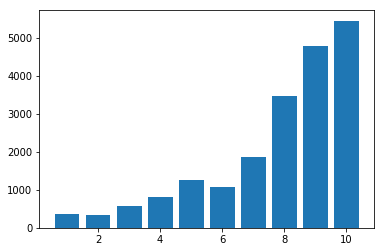

In [22]:
import matplotlib.pyplot as plt

score_stats = {i: 0 for i in range(1, 11)}
for score in scores:
    score_stats[score] += 1

plt.bar(score_stats.keys(), score_stats.values())
plt.show()

In [9]:
samples = {}
for line, score in text_corpus[:5000]:
    samples[score] = line
    
for i in range(1, 11):
    print("Score {}. Text: {}".format(i, samples[i]))

Score 1. Text: В литературном отношении - ниже плинтуса, но почитать имеет смысл, чтобы понять, как устроены мелкие пакостники.
Score 2. Text: Абсолютно согласна с nassy. Автор, ты кто? С чего ты взял, что можешь считать свои банальности истиной? желание возвыситься путем принижения остальных?? так это иллюзия высоты, не более того. Ощущение такое, что книгу "истина в тезисах" написал другой Мороз, а не тот, кто написал "Пособие для гениев". Короче, дрянь книга. А вот "Пособие для гениев" - рекомендую
Score 3. Text: Хрень полная! Похоже на переложенный на бумагу квест. Ходят, ищут, каакие-то подсказки неимоверные. Короче, поддерживаю amam - УЖОС!
Score 4. Text: Довольно бесхребетно и постыло. Однако, некоторые мометы попросту гениальны. Например, сцена с коммивояжером из самого начала.
Score 5. Text: Всё бы, может, и ничего, но эти слёзы-надрывы, надрывы-слёзы... На грани психического срыва, чесслово. И как-то слишком растянуто. Моя психика страдала :)
Score 6. Text: Смотрите, сейчас я

In [10]:
def filter_words(words):
    return list(filter(lambda x: x in special or x[0] in 'абвгдеёжзийклмнопрстуфхцчшщ' \
                       and x not in russian_stopwords, words))

In [11]:
corpus = []
for line, _ in lemmatized_text_corpus:
    line = filter_words(line)
    res = []
    for prev, word in zip([None] + line, line):
        if word == 'не':
            continue
        if prev == 'не':
            res.append("NOT_" + word)
        else:
            res.append(word)
    corpus.append(' '.join(res))
split_point = 19800
    
train, train_scores = corpus[:split_point], scores[:split_point]
test, test_scores = corpus[split_point:], scores[split_point:]

In [12]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(train)

In [23]:
features = vectorizer.get_feature_names()

In [16]:
regr = RandomForestRegressor(max_depth=10, n_estimators=1000)
regr.fit(X, train_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
clf = Lasso(max_iter=10000, alpha=0.0001)
clf.fit(X, train_scores)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature excl (0.119989)
2. feature not_понравиться (0.092019)
3. feature бред (0.079995)
4. feature очень (0.050982)
5. feature скучно (0.048806)
6. feature отличный (0.042369)
7. feature point point (0.033131)
8. feature плохой (0.029898)
9. feature beg (0.028733)
10. feature en (0.022153)
11. feature потратить (0.022120)
12. feature чушь (0.018162)
13. feature любимый (0.016153)
14. feature хороший (0.014967)
15. feature ужас excl (0.011848)
16. feature плохо (0.010578)
17. feature полный (0.010226)
18. feature тупой (0.010217)
19. feature скучный (0.009872)
20. feature отвратительный (0.009591)
21. feature книга (0.008633)
22. feature ничто (0.007816)
23. feature никакой (0.006754)
24. feature point (0.006745)
25. feature point en (0.004938)
26. feature фильм (0.004661)
27. feature слишком (0.004532)
28. feature дочитывать (0.004456)
29. feature гадость (0.003909)
30. feature myst (0.003573)
31. feature продюсер (0.003288)
32. feature отвратительно (0.003272)
33.

2854. feature вялый (0.000005)
2855. feature затрудняться (0.000005)
2856. feature уровень point (0.000005)
2857. feature коммунист (0.000005)
2858. feature быдло (0.000005)
2859. feature бушков (0.000005)
2860. feature начинать казаться (0.000005)
2861. feature монастырь (0.000005)
2862. feature not_отрываться (0.000005)
2863. feature крутиться (0.000005)
2864. feature книга плохой (0.000005)
2865. feature переходить (0.000005)
2866. feature point выход (0.000005)
2867. feature то очень (0.000005)
2868. feature групповой (0.000005)
2869. feature книга хороший (0.000005)
2870. feature блэк (0.000005)
2871. feature лицо главный (0.000005)
2872. feature скакать (0.000005)
2873. feature то подобный (0.000005)
2874. feature молодежный (0.000005)
2875. feature угораздить (0.000005)
2876. feature очень тяжелый (0.000005)
2877. feature комедийный (0.000005)
2878. feature point актер (0.000005)
2879. feature начало роман (0.000005)
2880. feature неплохой читаться (0.000005)
2881. feature beg о

4854. feature not_point en (0.000001)
4855. feature маслова (0.000001)
4856. feature злополучный (0.000001)
4857. feature отличный произведение (0.000001)
4858. feature написать excl (0.000001)
4859. feature разбегаться (0.000001)
4860. feature beg ожидать (0.000001)
4861. feature not_смотря (0.000001)
4862. feature свежий воздух (0.000001)
4863. feature фильм задумываться (0.000001)
4864. feature банальный point (0.000001)
4865. feature нежный (0.000001)
4866. feature школьник point (0.000001)
4867. feature not_судьба (0.000001)
4868. feature легкий чтение (0.000001)
4869. feature город point (0.000001)
4870. feature beg динамичный (0.000001)
4871. feature excl первый (0.000001)
4872. feature женщина который (0.000001)
4873. feature своеобразный (0.000001)
4874. feature прочее (0.000001)
4875. feature просто интересно (0.000001)
4876. feature соответствующий (0.000001)
4877. feature ти (0.000001)
4878. feature бондарчук (0.000001)
4879. feature иванов (0.000001)
4880. feature весь чел

7853. feature excl год (0.000000)
7854. feature досуг (0.000000)
7855. feature популярный point (0.000000)
7856. feature говорить книга (0.000000)
7857. feature атака (0.000000)
7858. feature акцент point (0.000000)
7859. feature охота (0.000000)
7860. feature признак (0.000000)
7861. feature утаскивать (0.000000)
7862. feature гражданин (0.000000)
7863. feature переигрывать (0.000000)
7864. feature коппол (0.000000)
7865. feature назваться (0.000000)
7866. feature крутить (0.000000)
7867. feature маринина (0.000000)
7868. feature карьер (0.000000)
7869. feature проклятие (0.000000)
7870. feature нудятина (0.000000)
7871. feature искалечивать (0.000000)
7872. feature обучать (0.000000)
7873. feature который уметь (0.000000)
7874. feature сторона point (0.000000)
7875. feature америка point (0.000000)
7876. feature вручать (0.000000)
7877. feature старый фильм (0.000000)
7878. feature понимать книга (0.000000)
7879. feature несколько секунда (0.000000)
7880. feature боевой искусство (0.

11353. feature детище (0.000000)
11354. feature not_редкий (0.000000)
11355. feature beg должный (0.000000)
11356. feature beg достойный (0.000000)
11357. feature beg глубоко (0.000000)
11358. feature застревать (0.000000)
11359. feature not_серьезный (0.000000)
11360. feature затаивать (0.000000)
11361. feature затериваться (0.000000)
11362. feature not_сдаваться (0.000000)
11363. feature beg герой (0.000000)
11364. feature деталь который (0.000000)
11365. feature детально (0.000000)
11366. feature затевать (0.000000)
11367. feature затаиваться (0.000000)
11368. feature затаивать дыхание (0.000000)
11369. feature not_связывать друг (0.000000)
11370. feature not_свой (0.000000)
11371. feature not_сатира (0.000000)
11372. feature детектив en (0.000000)
11373. feature beg главное (0.000000)
11374. feature not_рождаться (0.000000)
11375. feature детектив excl (0.000000)
11376. feature засыпать (0.000000)
11377. feature засылать (0.000000)
11378. feature not_самый страшный (0.000000)
11379

14352. feature год время (0.000000)
14353. feature point категорически (0.000000)
14354. feature point качественный (0.000000)
14355. feature год весь (0.000000)
14356. feature point класс (0.000000)
14357. feature point классик (0.000000)
14358. feature год myst (0.000000)
14359. feature point классика (0.000000)
14360. feature год en (0.000000)
14361. feature point ключевой (0.000000)
14362. feature point книжный (0.000000)
14363. feature гоголь (0.000000)
14364. feature point ко (0.000000)
14365. feature год жить (0.000000)
14366. feature point картина (0.000000)
14367. feature point истина (0.000000)
14368. feature год написание (0.000000)
14369. feature год рано (0.000000)
14370. feature год пять (0.000000)
14371. feature point истинный (0.000000)
14372. feature point исторический (0.000000)
14373. feature point исход (0.000000)
14374. feature год проходить (0.000000)
14375. feature год проживать (0.000000)
14376. feature год понимать (0.000000)
14377. feature год полный (0.000000

17852. feature халат (0.000000)
17853. feature хайнлайн (0.000000)
17854. feature хавьер бардем (0.000000)
17855. feature хавьер (0.000000)
17856. feature ха ха (0.000000)
17857. feature ха (0.000000)
17858. feature фюрер (0.000000)
17859. feature фэнтэзи point (0.000000)
17860. feature фэнтэзи (0.000000)
17861. feature фэнтезийный (0.000000)
17862. feature фэнтази (0.000000)
17863. feature футуристический (0.000000)
17864. feature футболист (0.000000)
17865. feature функция point (0.000000)
17866. feature функциональный (0.000000)
17867. feature фильм кевин (0.000000)
17868. feature фильм именно (0.000000)
17869. feature улица строитель (0.000000)
17870. feature утенок (0.000000)
17871. feature уступать место (0.000000)
17872. feature устремляться (0.000000)
17873. feature устранять (0.000000)
17874. feature устойчивый (0.000000)
17875. feature устой (0.000000)
17876. feature устанавливать (0.000000)
17877. feature усталый (0.000000)
17878. feature усталость (0.000000)
17879. feature 

20851. feature интересно место (0.000000)
20852. feature интересно книга (0.000000)
20853. feature интересно захватывающий (0.000000)
20854. feature интересно весь (0.000000)
20855. feature интересно excl (0.000000)
20856. feature интервью point (0.000000)
20857. feature интеллигенция (0.000000)
20858. feature интеллигентный (0.000000)
20859. feature интеллигентность (0.000000)
20860. feature интеллигент (0.000000)
20861. feature интеллектуальный детектив (0.000000)
20862. feature интеллектуально (0.000000)
20863. feature интеллектуал point (0.000000)
20864. feature инструмент (0.000000)
20865. feature инструкция (0.000000)
20866. feature институт point (0.000000)
20867. feature интересный вещь (0.000000)
20868. feature интересный герой (0.000000)
20869. feature интрига фильм (0.000000)
20870. feature интересный глубокий (0.000000)
20871. feature интрига который (0.000000)
20872. feature интерпретировать (0.000000)
20873. feature интерпретация point (0.000000)
20874. feature интернет p

In [19]:
test_X = vectorizer.transform(test)
regr.score(test_X, test_scores)

0.11129376875123176

In [20]:
regr.score(X, train_scores)

0.23049910709332078

In [21]:
with open('dataset.txt', 'r') as file:
    with open('answer.txt', 'w') as out:
        qs = []
        for line in file:
            line = filter_words(['beg'] + map_punct(m.lemmatize(line)) + ['en'])
            res = []
            for prev, word in zip([None] + line, line):
                if word == 'не':
                    continue
                if prev == 'не':
                    res.append("NOT_" + word)
                else:
                    res.append(word)
            qs.append(' '.join(res))
        q_X = vectorizer.transform(qs)
        ys = clf.predict(q_X)
        
        for y in ys:
            result = round(y / 10 * 12 - 1)
            result = max(min(10, int(result)), 1)
            out.write("{}\n".format(result))